In [ ]:
!nvidia-smi

In [ ]:
''' Installing some required libraries. '''
!pip install python-levenshtein torchsummaryX wandb kaggle pytorch-nlp --quiet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/


##  Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as tat

from torchsummary import summary
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import gc
import os
import math
import yaml
import random
import zipfile
import datetime

import glob
import wandb
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

''' Imports for decoding and distance calculation. '''
import Levenshtein

import warnings
warnings.filterwarnings("ignore")
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests
from PIL import Image
import json
from sklearn.model_selection import train_test_split
import cv2
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

# Configurations

In [ ]:
%%writefile config.yaml

###### Dataset -----------------------------------------------------------------
train_dataset   : "train-clean-100"     # train-clean-50 (primarily for debugging purposes), train-clean-100
cepstral_norm   : True
input_dim       : 27
batch_size      : 64                    # decrease this as you modify the network architecture

###### Encoder Parameters ------------------------------------------
## Universal (Part I and II)
enc_dropout     : 0.2                   # [0.1, 0.4]
## Transformer-related (Part II)
enc_num_layers  : 1                     # [1, 3]
enc_num_heads   : 1                     # [1, 4]

###### Decoder Parameters ------------------------------------------
## Transformer-related (Part I and II)
dec_dropout     : 0.2                   # [0.1, 0.4]
dec_num_layers  : 4                     # [1, 3]
dec_num_heads   : 4                     # [1, 4]

###### Network Parameters ------------------------------------------------------
d_model         : 512                   # [256, 1024]
d_ff            : 2048                  # [512, 4096]

###### Learning Rate ---------------------------------------------------------------
learning_rate   : 1E-4                  # [1E-3, 1E-4], this will depend on the specified optimizer

###### Optimizer ---------------------------------------------------------------
optimizer       : "AdamW"               # Adam, AdamW

## if SGD
momentum        : 0.0
nesterov        : True

###### Scheduler ---------------------------------------------------------------
scheduler       : "CosineAnnealing"     # CosineAnnealing, ReduceLR

## if ReduceLR

## we are validating every 2 epochs but scheduler acts on every epoch. Set patience accordingly
## patience less than validation frquency can mean learning rate always dropping after patience epochs
## specify a suitable threshold too
factor          : 0.9
patience        : 6

###### Training Parameters -----------------------------------------------------
epochs          : 100

###### Name --------------------------------------------------------------------
Name: "idl_man_4"                                # write your name here for study group

In [ ]:
with open("config.yaml") as file:
    config = yaml.safe_load(file)

In [ ]:
config

In [ ]:
with open('/content/drive/MyDrive/HHD-Ethiopic/dictionary_fixed.json', encoding="utf-8") as json_file:
    raw_data = json_file.read()
raw_data = json.loads(raw_data)
# raw_data["307"] = "<sos>"
# raw_data["308"] = "<eos>"


In [ ]:
x = np.load("train_numpy/x_train.npy", allow_pickle=True)
y = np.load("train_numpy/y_train.npy", allow_pickle=True)
# Split into 80% training and 20% validation
x, x_val, y, y_val = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)


print(len(x_val), len(x) )

In [ ]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")


In [ ]:
VOCAB = [
    "<pad>", "<sos>", "<eos>",
] + list(raw_data.values())

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}

PAD_TOKEN = VOCAB_MAP["<pad>"]
SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

print(f"Length of Vocabulary    : {len(VOCAB)}")
print(f"VOCAB                   : {VOCAB}")
print(f"PAD_TOKEN               : {PAD_TOKEN}")
print(f"SOS_TOKEN               : {SOS_TOKEN}")
print(f"EOS_TOKEN               : {EOS_TOKEN}")

In [ ]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

In [ ]:
''' This class is very similar to HW3P2 except for targets (now sequence of characters). '''

class AmharicOcrDataset(torch.utils.data.Dataset):
    ''' memory inefficient : loading data in __init__ for simplicty

        You may decide to load data in __getitem__ if you wish.
        However, doing this memory inefficiently makes __init__ function takes
        the load of loading the data, and shifts it away from during the training process.
    '''

    def __init__(self, images_array, transcript_array, processor):


        self.images = []
        self.transcript = transcript_array

        self.processor = processor

        for image in images_array:
          image  =cv2.resize(image/255.0, dsize=(224, 224))
          image = np.dstack((image,image,image))
          # pixel_values = self.processor(image, return_tensors="pt",do_rescale=False).pixel_values

          self.images.append(image)

        self.transcripts_shifted = []
        self.transcripts_golden = []



        for temp in self.transcript:
            # temp = np.load(file)[1:-1]

            # Why do we have two different types of targets?
            # How do we want our decoder to know the start of sequence <SOS> and end of sequence <EOS>?

            # @TODO: Uncomment the code below after answering the above questions.
            self.transcripts_shifted.append(np.array([SOS_TOKEN] + [i for i in temp if i != 0]))
            self.transcripts_golden.append(np.array([i for i in temp if i != 0] + [EOS_TOKEN]))
        self.length         = len(self.images)
        assert len(self.images) == len(self.transcripts_shifted)


    def __len__(self): return self.length


    def __getitem__(self, ind):
        image                = torch.FloatTensor(self.images[ind])
        shifted_transcript  = torch.tensor(self.transcripts_shifted[ind])
        golden_transcript   = torch.tensor(self.transcripts_golden[ind])

        return image, shifted_transcript, golden_transcript


    def collate_fn(self, batch):
        # @NOTE: batch corresponds to output from __getitem__ for a minibatch

        '''
        1.  Extract the features and labels from 'batch'.
        2.  We will additionally need to pad both features and labels,
            look at PyTorch's documentation for pad_sequence.
        3.  This is a good place to perform transforms, if you so wish.
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lengths of features, and lengths of labels.

        '''

        batch_images              = [self.processor( i[0] , return_tensors="pt",do_rescale=False).pixel_values for i in batch]

        # Batch of output characters (shifted and golden).
        batch_transcript        = [i[1] for i in batch]
        batch_golden            = [i[2] for i in batch]

        lengths_mfcc            = [len(i) for i in batch_images]
        lengths_transcript      = [len(i) for i in batch_transcript]


        batch_images_pad          = pad_sequence(batch_images, batch_first=True, padding_value=PAD_TOKEN)
        batch_transcript_pad    = pad_sequence(batch_transcript, batch_first=True, padding_value=PAD_TOKEN)
        batch_golden_pad        = pad_sequence(batch_golden, batch_first=True, padding_value=PAD_TOKEN)


        # You may apply some transformations, Time and Frequency masking, here in the collate function:
        # Food for Thought -> Why are we applying the transformation here and not in the __getitem__?
        #                  -> Would we apply transformation on the validation set as well?
        #                  -> Is the order of axes / dimensions as expected for the transform functions?


        # Return the following values:
        # padded features, padded shifted labels, padded golden labels, actual length of features, actual length of the shifted labels
        return batch_images_pad, batch_transcript_pad, batch_golden_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)

In [ ]:
import torch
import cv2
import numpy as np
from torch.nn.utils.rnn import pad_sequence

class AmharicOcrDataset(torch.utils.data.Dataset):
    def __init__(self, images_array, transcript_array, processor):
        self.images_paths = images_array  # Store only paths, not images
        self.transcript = transcript_array
        self.processor = processor
        self.length = len(images_array)

    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        # Load image only when needed
        image = self.images_paths[ind]
        image = cv2.resize(image / 255.0, (224, 224))
        image = np.dstack((image, image, image))  # Convert to 3-channel
        image = torch.FloatTensor(image)

        shifted_transcript = torch.tensor([SOS_TOKEN] + [i for i in self.transcript[ind] if i != 0])
        golden_transcript = torch.tensor([i for i in self.transcript[ind] if i != 0] + [EOS_TOKEN])

        return image, shifted_transcript, golden_transcript

    def collate_fn(self, batch):
        batch_images = [self.processor(i[0], return_tensors="pt", do_rescale=False).pixel_values for i in batch]
        batch_transcript = [i[1] for i in batch]
        batch_golden = [i[2] for i in batch]

        lengths_mfcc = [len(i) for i in batch_images]
        lengths_transcript = [len(i) for i in batch_transcript]

        batch_images_pad = pad_sequence(batch_images, batch_first=True, padding_value=PAD_TOKEN)
        batch_transcript_pad = pad_sequence(batch_transcript, batch_first=True, padding_value=PAD_TOKEN)
        batch_golden_pad = pad_sequence(batch_golden, batch_first=True, padding_value=PAD_TOKEN)

        return batch_images_pad, batch_transcript_pad, batch_golden_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)


In [ ]:
train_dataset   = AmharicOcrDataset(
x,y,processor
)

val_dataset   = AmharicOcrDataset(
x_val,y_val,processor
)
gc.collect()


In [ ]:

train_loader    = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    batch_size  = config["batch_size"],
    shuffle     = True,
    num_workers = 4,
    pin_memory  = True,
    collate_fn  = train_dataset.collate_fn
)

val_loader      = torch.utils.data.DataLoader(
    dataset     = val_dataset,
    batch_size  = config["batch_size"],
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True,
    collate_fn  = val_dataset.collate_fn,
)

print("No. of Train Images   : ", train_dataset.__len__())
print("Batch Size           : ", config["batch_size"])
print("Train Batches        : ", train_loader.__len__())
print("Val Batches          : ", val_loader.__len__())

In [ ]:
''' Sanity Check '''

print("Checking the Shapes of the Data --\n")

for batch in train_loader:
    x_pad, y_shifted_pad, y_golden_pad, x_len, y_len, = batch

    print(f"x_pad shape:\t\t{x_pad.shape}")
    print(f"x_len shape:\t\t{x_len.shape}\n")

    print(f"y_shifted_pad shape:\t{y_shifted_pad.shape}")
    print(f"y_golden_pad shape:\t{y_golden_pad.shape}")
    print(f"y_len shape:\t\t{y_len.shape}\n")

    # print(y_shifted_pad)

    break

In [ ]:
def create_mask_1(padded_input, input_lengths=None, pad_idx=None):
    """ Create a mask to identify non-padding positions.

    Args:
        padded_input: The input tensor with padding, shape (N, T, ...) or (N, T).
        input_lengths: Optional, the actual lengths of each sequence before padding, shape (N,).
        pad_idx: Optional, the index used for padding tokens.

    Returns:
        A mask tensor with shape (N, T, 1), where non-padding positions are marked with 1 and padding positions are marked with 0.
    """

    assert input_lengths is not None or pad_idx is not None

    # Create a mask based on input_lengths
    if input_lengths is not None:
        N = padded_input.size(0)        # padded_input : (N x T x ...)
        non_pad_mask = padded_input.new_ones(padded_input.size()[:-1])  # (N x T)

        # Set the mask to 0 for padding positions
        for i in range(N):
          non_pad_mask[i, input_lengths[i]:] = 0

    if pad_idx is not None:             # padded_input : N x T

        assert padded_input.dim() == 2

        # Create a mask where non-padding positions are marked with 1 and padding positions are marked with 0
        non_pad_mask = padded_input.ne(pad_idx).float()

    return non_pad_mask.unsqueeze(-1)   # unsqueeze(-1) for broadcasting

def create_mask_2(seq, pad_idx=None):
    """ Create a mask to prevent positions from attending to subsequent positions.

    Args:
        seq: The input sequence tensor, shape (batch_size, sequence_length).

    Returns:
        A mask tensor with shape (batch_size, sequence_length, sequence_length),
            where positions are allowed to attend to previous positions but not to subsequent positions.
    """

    sz_b, len_s = seq.size()

    # Create an upper triangular matrix with zeros on the diagonal and below (indicating allowed positions)
    #   and ones above the diagonal (indicating disallowed positions)
    subsequent_mask = torch.triu(
        torch.ones((len_s, len_s), device=seq.device, dtype=torch.uint8), diagonal=1)

    # Expand the mask to match the batch size, resulting in a mask for each sequence in the batch.
    mask = subsequent_mask.unsqueeze(0).expand(sz_b, -1, -1)  # b x ls x ls


    ''' Create a mask to ignore padding positions in the key sequence during attention calculation. '''

    # Expanding to fit the shape of key query attention matrix.
    if pad_idx != None:
      len_q = seq.size(1)

      # Create a mask where padding positions in the key sequence are marked with 1.
      padding_mask  = seq.eq(pad_idx)

      # Expand the mask to match the dimensions of the key-query attention matrix.
      padding_mask  = padding_mask.unsqueeze(1).expand(-1, len_q, -1)  # b x lq x lk
      mask          = (padding_mask + mask).gt(0)

    else:
      mask = mask.gt(0)

    return mask

def create_mask_3(padded_input, input_lengths, expand_length):
    """ Create an attention mask to ignore padding positions in the input sequence during attention calculation.

    Args:
        padded_input: The input tensor with padding, shape (N, Ti, ...).
        input_lengths: The actual lengths of each sequence before padding, shape (N,).
        expand_length: The length to which the attention mask should be expanded,
            usually equal to the length of the sequence that the attention scores will be applied to.

    Returns:
        An attention mask tensor with shape (N, expand_length, Ti),
            where padding positions in the input sequence are marked with 1 and other positions are marked with 0.
    """

    # Create a mask to identify non-padding positions, shape (N, Ti, 1)
    # (N x Ti x 1)
    non_pad_mask    = create_mask_1(padded_input, input_lengths=input_lengths)

    # Invert the mask to identify padding positions, shape (N, Ti)
    # N x Ti, lt(1) like-not operation
    pad_mask        = non_pad_mask.squeeze(-1).lt(1)


    # Expand the mask to match the dimensions of the attention matrix, shape (N, expand_length, Ti)
    attn_mask       = pad_mask.unsqueeze(1).expand(-1, expand_length, -1)

    return attn_mask

In [ ]:
class ScaledDotProductAttention(torch.nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature    = temperature                       # Scaling factor for the dot product
        self.dropout        = torch.nn.Dropout(attn_dropout)    # Dropout layer for attention weights
        self.softmax        = torch.nn.Softmax(dim=2)           # Softmax layer along the attention dimension

    def forward(self, q, k, v, mask=None):

        # Calculate the dot product between queries and keys.
        attn = torch.bmm(q, k.transpose(1, 2))

        # Scale the dot product by the temperature.
        attn = attn / self.temperature

        if mask is not None:
            # Apply the mask by setting masked positions to a large negative value.
            # This ensures they have a softmax score close to zero.
            mask_value = -1e+30 if attn.dtype == torch.float32 else -1e+4
            attn = attn.masked_fill(mask, mask_value)

        # Apply softmax to obtain attention weights.
        attn    = self.softmax(attn)

        # Apply dropout to the attention weights.
        attn    = self.dropout(attn)

        # Compute the weighted sum of values based on the attention weights.
        output  = torch.bmm(attn, v)

        return output, attn # Return the attention output and the attention weights.
def save_attention_plot(attention_weights, epoch=0):
    ''' function for saving attention weights plot to a file

        @NOTE: default starter code set to save cross attention
    '''

    plt.clf()  # Clear the current figure
    sns.heatmap(attention_weights, cmap="GnBu")  # Create heatmap

    # Save the plot to a file. Specify the directory if needed.
    plt.savefig(f"cross_attention-epoch{epoch}.png")

class MultiHeadAttention(torch.nn.Module):
    ''' Multi-Head Attention Module '''

    def __init__(self, n_head, d_model, dropout=0.1):
        super().__init__()

        self.n_head = n_head # Number of attention heads
        self.d_k    = d_model // n_head
        self.d_v    = d_model // n_head


        # Linear layers for projecting the input query, key, and value to multiple heads
        self.w_qs   = torch.nn.Linear(d_model, n_head * self.d_k)
        self.w_ks   = torch.nn.Linear(d_model, n_head * self.d_k)
        self.w_vs   = torch.nn.Linear(d_model, n_head * self.d_v)

        torch.nn.init.normal_(self.w_qs.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_k)))
        torch.nn.init.normal_(self.w_ks.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_k)))
        torch.nn.init.normal_(self.w_vs.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_v)))

        # Initialize the weights of the linear layers
        self.attention = ScaledDotProductAttention(
            temperature=np.power(self.d_k, 0.5), attn_dropout=dropout)

        # Final linear layer to project the concatenated outputs of the attention heads back to the model dimension
        self.fc = torch.nn.Linear(n_head * self.d_v, d_model)

        torch.nn.init.xavier_normal_(self.fc.weight)

        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):

        # following key, value, query standard computation
        d_k, d_v, n_head    = self.d_k, self.d_v, self.n_head
        sz_b, len_q, _      = q.size()
        sz_b, len_k, _      = k.size()
        sz_b, len_v, _      = v.size()

        # Project the input query, key, and value to multiple heads
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        # Rearrange the dimensions to group the heads together for parallel processing
        q = q.permute(2, 0, 1, 3).contiguous().view(-1, len_q, d_k) # (n*b) x lq x dk
        k = k.permute(2, 0, 1, 3).contiguous().view(-1, len_k, d_k) # (n*b) x lk x dk
        v = v.permute(2, 0, 1, 3).contiguous().view(-1, len_v, d_v) # (n*b) x lv x dv

        # Repeat the mask for each attention head if a mask is provided
        if mask is not None:
            mask = mask.repeat(n_head, 1, 1)

        # Apply scaled dot-product attention to the projected query, key, and value
        output, attn    = self.attention(q, k, v, mask=mask)

        # Rearrange the output back to the original order and concatenate the heads
        output          = output.view(n_head, sz_b, len_q, d_v)
        output          = output.permute(1, 2, 0, 3).contiguous().view(sz_b, len_q, -1) # b x lq x (n*dv)

        output          = self.dropout(self.fc(output))

        return output, attn
class PositionalEncoding(torch.nn.Module):
    ''' Position Encoding from Attention Is All You Need Paper '''

    def __init__(self, d_model, max_len=5000):
        super().__init__()

        # Initialize a tensor to hold the positional encodings
        pe          = torch.zeros(max_len, d_model)

        # Create a tensor representing the positions (0 to max_len-1)
        position    = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Calculate the division term for the sine and cosine functions
        # This term creates a series of values that decrease geometrically, used to generate varying frequencies for positional encodings
        div_term    = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Compute the positional encodings using sine and cosine functions
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Reshape the positional encodings tensor and make it a buffer
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):

      return x + self.pe[:, :x.size(1)]
class FeedForward(torch.nn.Module):
    ''' Projection Layer (Fully Connected Layers) '''

    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()

        self.linear_1   = torch.nn.Linear(d_model, d_ff)
        self.dropout    = torch.nn.Dropout(dropout)
        self.linear_2   = torch.nn.Linear(d_ff, d_model)

    def forward(self, x):

        # Apply the first linear layer, GeLU activation, and then dropout
        x = self.dropout(torch.nn.functional.gelu(self.linear_1(x)))

         # Apply the second linear layer to project the dimension back to d_model
        x = self.linear_2(x)

        return x

In [ ]:
class DecoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        # @TODO: fill in the blanks appropriately (given the modules above)
        self.mha1       = MultiHeadAttention(num_heads, d_model, dropout=dropout)
        self.mha2       = MultiHeadAttention(num_heads, d_model, dropout=dropout)
        self.ffn        = FeedForward(d_model, d_ff)

        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.layernorm3 = nn.LayerNorm(d_model)

        self.dropout1   = nn.Dropout(p=dropout)
        self.dropout2   = nn.Dropout(p=dropout)
        self.dropout3   = nn.Dropout(p=dropout)


    def forward(self, padded_targets, enc_output, enc_input_lengths, dec_enc_attn_mask, pad_mask, slf_attn_mask):

        output1, attn_weights1 = self.mha1(padded_targets, padded_targets, padded_targets, slf_attn_mask )

        # Skip (Residual) Connections
        #   (1) perform dropout on padded attention output
        output1 = self.dropout1(output1)
        #   (2) add the true outputs (padded_targets) as a skip connection

#         ''' TODO '''

        # Layer Normalization
        #   (1) call layernorm on this resulting value
        output1 = self.layernorm1(output1 +  padded_targets)

#         ''' TODO '''

        # Masked Multi-Head Attention on Encoder Outputs and Targets
        #   (1) apply MHA with the self-attention mask
        #forward(self, q, k, v, mask=None)


        output2, attn_weights2 = self.mha2(output1, enc_output, enc_output, dec_enc_attn_mask )


#         ''' TODO '''

        # Skip (Residual) Connections
        #   (1) perform dropout on this second padded attention output
        output2 = self.dropout2(output2)

        #   (2) add the output of first MHA block as a skip connection

#         ''' TODO '''

        # Layer Normalization
        #   (1) call layernorm on this resulting value

        output2 = self.layernorm2(output2 + output1)

#         ''' TODO '''

        # Feed Forward Network
        #   (1) pass through the FFN
        ffn_out = self.ffn(output2)
#         ''' TODO '''

        # Skip (Residual) Connections
        #   (1) perform dropout on the output
        ffn_out = self.dropout3(ffn_out)


        #   (2) add the output of second MHA block as a skip connection

        #''' TODO '''

        # apply Layer Normalization onto output of feed-forward network
        output3 = self.layernorm3(ffn_out + output2)
        return output3, attn_weights1, attn_weights2

class Decoder(torch.nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout,
            target_vocab_size, max_seq_length, eos_token, sos_token, pad_token):
        super().__init__()

        self.EOS_TOKEN      = eos_token
        self.SOS_TOKEN      = sos_token
        self.PAD_TOKEN      = pad_token

        self.max_seq_length = max_seq_length
        self.num_layers     = num_layers

        # use torch.nn.ModuleList() with list comprehension looping through num_layers
        # @NOTE: think about what stays constant per each DecoderLayer (how to call DecoderLayer)
        # @HINT: We've implemented this for you.
        self.dec_layers = torch.nn.ModuleList(
            [DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)]
        )

        self.target_embedding       = nn.Embedding(target_vocab_size, d_model)
        self.positional_encoding    = PositionalEncoding(d_model, max_len=max_seq_length)
        self.final_linear           = nn.Linear(d_model, target_vocab_size)
        self.dropout                = nn.Dropout(p=dropout)


    def forward(self, padded_targets, enc_output, enc_input_lengths):

        pad_mask = create_mask_1(padded_targets,  pad_idx= self.PAD_TOKEN)

        look_ahead_mask = create_mask_2(padded_targets,  pad_idx= self.PAD_TOKEN) ##

        dec_enc_attn_mask = create_mask_3(enc_output, enc_input_lengths,padded_targets.shape[1])

        target_embedded = self.target_embedding(padded_targets)


        target_embedded = self.positional_encoding(target_embedded)

        target_embedded = self.dropout(target_embedded)

        running_attn = {}


        for i, layer in enumerate(self.dec_layers):
            target_embedded, attn1, attn = layer(target_embedded, enc_output, enc_input_lengths, dec_enc_attn_mask, pad_mask, look_ahead_mask)
            running_attn['layer{}_dec_self'.format(i + 1)] = attn1
            running_attn['layer{}_dec_self'.format(i + 1)] =  attn


        # target_embedded = self.layer_norm(target_embedded)
        out = self.final_linear(target_embedded)


        return out, running_attn
        raise NotImplemented


    def recognize_greedy_search(self, enc_outputs, enc_input_lengths):
        ''' passes the encoder outputs and its corresponding lengths through autoregressive network

            @NOTE: You do not need to make changes to this method.
        '''

        batch_size = enc_outputs.size(0)

        # start with the <SOS> token for each sequence in the batch
        target_seq = torch.full((batch_size, 1), self.SOS_TOKEN, dtype=torch.long).to(enc_outputs.device)

        finished = torch.zeros(batch_size, dtype=torch.bool).to(enc_outputs.device)

        for _ in range(self.max_seq_length):

            # preparing attention masks
            # filled with ones becaues we want to attend to all the elements in the sequence
            pad_mask = torch.ones_like(target_seq).float().unsqueeze(-1)  # (batch_size x i x 1)
            slf_attn_mask_subseq = create_mask_2(target_seq)

            x = self.positional_encoding(self.target_embedding(target_seq))

            for i in range(self.num_layers):
                x, block1, block2 = self.dec_layers[i](
                    x, enc_outputs, enc_input_lengths, None, pad_mask, slf_attn_mask_subseq)

            seq_out = self.final_linear(x[:, -1])
            logits = torch.nn.functional.log_softmax(seq_out, dim=1)

            # selecting the token with the highest probability
            # @NOTE: this is the autoregressive nature of the network!
            next_token = logits.argmax(dim=-1).unsqueeze(1)

            # appending the token to the sequence
            target_seq = torch.cat([target_seq, next_token], dim=-1)

            # checking if <EOS> token is generated
            eos_mask = next_token.squeeze(-1) == self.EOS_TOKEN
            # or opration, if both or one of them is true store the value of the finished sequence in finished variable
            finished |= eos_mask

            # end if all sequences have generated the EOS token
            if finished.all(): break

        # remove the initial <SOS> token and pad sequences to the same length
        target_seq = target_seq[:, 1:]
        max_length = target_seq.size(1)
        target_seq = torch.nn.functional.pad(target_seq,
            (0, self.max_seq_length - max_length), value=self.PAD_TOKEN)

        return target_seq

In [ ]:
class SpeechTransformer(torch.nn.Module):

    def __init__(self, input_dim, dec_num_layers, dec_num_heads,
                    d_model, d_ff, target_vocab_size, eos_token, sos_token,
                    pad_token, enc_dropout, dec_dropout, max_seq_length=512):

        super(SpeechTransformer, self).__init__()

        # self.encoder    = CNN_LSTM_Encoder(input_dim, 256, enc_dropout)
        # Load TrOCR model (encoder only)
        self.processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
        self.encoder = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten").encoder

        # Extract `d_model` from TrOCR encoder
        enc_d_model = self.encoder.config.hidden_size
        self.proj       = torch.nn.Linear(enc_d_model, d_model)

        # @NOTE: layernorm here is meant to normalize the dynamic ranges of
        #   the cross attention weights such that the model doesn't bias
        #   itself to only using the cross attention weights and neglect using
        #   the multi-head self attention weights.
        #   This is to enfoce the Language Model constraints in the Decoder.
        #   This is an experimental change -- you may try it if you want.
        self.layernorm  = torch.nn.LayerNorm(d_model)

        self.decoder    = Decoder(dec_num_layers, d_model, dec_num_heads, d_ff,
                dec_dropout, target_vocab_size, max_seq_length, eos_token, sos_token, pad_token)

        # You can experiment with different weight initialization schemes or no initialization here
        for p in self.parameters():
            if p.dim() > 1:
                torch.nn.init.xavier_uniform_(p)

    def forward(self, padded_input, input_lengths, padded_target, target_lengths):
        padded_input = padded_input.squeeze(1)
        # passing through Encoder
        # encoder_output, encoder_lens = self.encoder(padded_input)
        # with torch.inference_mode():
        encoder_output = self.encoder(padded_input)["last_hidden_state"]  # Shape: (batch_size, num_patches+1, d_model)

        encoder_lens = torch.tensor([encoder_output.shape[1]] * encoder_output.shape[0] )

        # adding projection layer to change dimension of encoder_outputs to match d_model
        encoder_output = self.proj(encoder_output)

        # @NOTE: adding layernorm to adjust dynamic ranges of the encoder_outputs
        # @NOTE: uncomment this if you choose to use layernorm described in __init__ above
        encoder_output = self.layernorm(encoder_output)

        # passing Encoder output and Attention masks through Decoder
        output, attention_weights = self.decoder(padded_target, encoder_output, encoder_lens)

        return output, attention_weights

    def recognize(self, inp, inp_len):
        """ sequence-to-sequence greedy search -- decoding one utterence at a time """

        # encoder_outputs, encoder_lens  = self.encoder(inp, inp_len)
        inp = inp.squeeze(1)
        # passing through Encoder
        # encoder_output, encoder_lens = self.encoder(padded_input)
        with torch.inference_mode():
          encoder_output = self.encoder(inp)["last_hidden_state"]  # Shape: (batch_size, num_patches+1, d_model)

        encoder_lens = torch.tensor([encoder_output.shape[1]] * encoder_output.shape[0] )
        encoder_output                = self.proj(encoder_output)
        out                            = self.decoder.recognize_greedy_search(encoder_output, encoder_lens)

        return out

## Model Setup


In [ ]:

torch.cuda.empty_cache()
gc.collect()

In [ ]:
''' Please refer to the config file and top sections to fill in the following '''

model = SpeechTransformer(
input_dim                   = config["input_dim"],
dec_num_layers              = config["dec_num_layers"],
dec_num_heads               = config["dec_num_heads"],

d_model                     = config["d_model"],
d_ff                        = config["d_ff"],

target_vocab_size           = len(VOCAB),
eos_token                   = EOS_TOKEN,
sos_token                   = SOS_TOKEN,
pad_token                   = PAD_TOKEN,

enc_dropout                 = config["enc_dropout"],
dec_dropout                 = config["enc_dropout"],

# decrease to a small number if you are just trying to implement the network
max_seq_length              = 48 , # Max sequence length for transcripts. Check data verification.
).to(device)

def num_parameters(mode):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params / 1E6

para = num_parameters(model)
print("#"*10)
print(f"Model Parameters:\n {para}")
print("#"*10)

## Loss, Optimizer, and Scheduler Definitions

In [ ]:
loss_func   = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN)
scaler      = torch.cuda.amp.GradScaler()

In [ ]:
''' defining optimizer '''

if config["optimizer"] == "SGD":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.SGD(model.parameters(),
                              lr=config["learning_rate"],
                              momentum=config["momentum"],
                              weight_decay=1E-4,
                              nesterov=config["nesterov"])

elif config["optimizer"] == "Adam":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.Adam(model.parameters(),
                               lr=float(config["learning_rate"]),
                               weight_decay=1e-4)

elif config["optimizer"] == "AdamW":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.AdamW(model.parameters(),
                                lr=float(config["learning_rate"]),
                                weight_decay=0.01)

''' defining scheduler '''

if config["scheduler"] == "ReduceLR":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                factor=config["factor"], patience=config["patience"], min_lr=1E-8, verbose=True)

elif config["scheduler"] == "CosineAnnealing":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                T_max = 35, eta_min=1E-8)

In [ ]:
def save_model(model, optimizer, scheduler, metric, epoch, path):
    torch.save(
        {"model_state_dict"         : model.state_dict(),
         "optimizer_state_dict"     : optimizer.state_dict(),
         "scheduler_state_dict"     : scheduler.state_dict() if scheduler is not None else {},
         metric[0]                  : metric[1],
         "epoch"                    : epoch},
         path
    )

def load_model(path, model, metric= "valid_acc", optimizer= None, scheduler= None):

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model_state_dict"])

    if optimizer != None:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    if scheduler != None:
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

    epoch   = checkpoint["epoch"]
    metric  = checkpoint[metric]

    return [model, optimizer, scheduler, epoch, metric]

## Training and Validation Modules

### Levenshtein Distance

In [ ]:
''' utility function which takes a sequence of indices and converts them to a list of characters '''
def indices_to_chars(indices, vocab):
    tokens = []
    for i in indices:   # looping through all indices

        if int(i) == SOS_TOKEN:     # If SOS is encountered, don't add it to the final list
            continue
        elif int(i) == EOS_TOKEN:   # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(vocab[i])

    return tokens

In [ ]:
''' utility function for Levenshtein Distantce quantification '''
def calc_edit_distance(predictions, y, y_len, vocab=VOCAB, print_example=False):

    dist = 0.0
    batch_size, seq_len = predictions.shape

    for batch_idx in range(batch_size):

        y_sliced    = indices_to_chars(y[batch_idx, 0 : y_len[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        # strings - when you are using characters from the SpeechDataset
        y_string    = "".join(y_sliced)
        pred_string = "".join(pred_sliced)

        dist        += Levenshtein.distance(pred_string, y_string)

    if print_example:
        print("\nGround Truth : ", y_string)
        print("Prediction   : ", pred_string)

    dist /= batch_size

    return dist

### Training and Validation Functions

In [ ]:
def train_model(model, train_loader, optimizer):

    model.train()
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc="Train")

    total_loss          = 0
    running_loss        = 0.0
    running_perplexity  = 0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(train_loader):

        optimizer.zero_grad()

        inputs          = inputs.to(device)
        targets_shifted = targets_shifted.to(device)
        targets_golden  = targets_golden.to(device)

        with torch.cuda.amp.autocast():
            # passing the minibatch through the model
            # raw_predictions, attention_weights = model(inputs, inputs_lengths, targets_shifted, targets_lengths)
            raw_predictions, attention_weights = model(inputs, inputs_lengths, targets_shifted, targets_lengths)


            padding_mask = torch.logical_not(torch.eq(targets_shifted, PAD_TOKEN))

            # cast the mask to float32
            padding_mask = padding_mask.float()
            loss = loss_func(raw_predictions.transpose(1,2), targets_golden)*padding_mask
            loss = loss.sum() / padding_mask.sum()

        scaler.scale(loss).backward()   # This is a replacement for loss.backward()
        scaler.step(optimizer)          # This is a replacement for optimizer.step()
        scaler.update()                 # This is something added just for FP16

        running_loss        += float(loss.item())
        perplexity          = torch.exp(loss)
        running_perplexity  += perplexity.item()

        # online training monitoring
        batch_bar.set_postfix(
            loss = "{:.04f}".format(float(running_loss / (i + 1))),
            perplexity = "{:.04f}".format(float(running_perplexity / (i + 1)))
        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()

    running_loss        = float(running_loss / len(train_loader))
    running_perplexity  = float(running_perplexity / len(train_loader))

    batch_bar.close()

    return running_loss, running_perplexity, attention_weights

In [ ]:
def validate_fast(model, dataloader):
    model.eval()

    # progress bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc="Val", ncols=5)

    running_distance = 0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(dataloader):

        inputs  = inputs.to(device)
        targets_golden = targets_golden.to(device)

        with torch.inference_mode():
            greedy_predictions = model.recognize(inputs, inputs_lengths)

        # calculating Levenshtein Distance
        # @NOTE: modify the print_example to print more or less validation examples
        running_distance += calc_edit_distance(greedy_predictions, targets_golden, targets_lengths, VOCAB, print_example=True)

        # online validation distance monitoring
        batch_bar.set_postfix(
            running_distance = "{:.04f}".format(float(running_distance / (i + 1)))
        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()

        if i==4: break      # validating only upon first five batches

    batch_bar.close()
    running_distance /= 5

    return running_distance

In [ ]:
def validate_full(model, dataloader):
    model.eval()

    # progress bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc="Val", ncols=5)

    running_distance = 0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(dataloader):

        inputs  = inputs.to(device)
        targets_golden = targets_golden.to(device)

        with torch.inference_mode():
            greedy_predictions = model.recognize(inputs, inputs_lengths)

        # calculating Levenshtein Distance
        # @NOTE: modify the print_example to print more or less validation examples
        running_distance += calc_edit_distance(greedy_predictions, targets_golden, targets_lengths, VOCAB, print_example=True)

        # online validation distance monitoring
        batch_bar.set_postfix(
            running_distance = "{:.04f}".format(float(running_distance / (i + 1)))
        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()


    batch_bar.close()
    running_distance /= len(dataloader)

    return running_distance

## WandB

In [ ]:
# using WandB? resume training?

USE_WANDB = True
RESUME_LOGGING = False

# creating your WandB run
run_name = "{}_Transformer_ENC-{}/{}_DEC-{}/{}_{}_{}_{}_{}".format(
    config["Name"],
    config["enc_num_layers"],       # only used in Part II with the Transformer Encoder
    config["enc_num_heads"],        # only used in Part II with the Transformer Encoder
    config["dec_num_layers"],
    config["dec_num_heads"],
    config["d_model"],
    config["d_ff"],
    config["optimizer"],
    config["scheduler"])

if USE_WANDB:

    wandb.login(key="3c7b273814544590b64c54d9a5242bde38616e02", relogin=True) # TODO enter your key here

    if RESUME_LOGGING:
        run_id = ""
        run = wandb.init(
            id     = run_id,        ### Insert specific run id here if you want to resume a previous run
            resume = True,          ### You need this to resume previous runs, but comment out reinit=True when using this
            project = "HW4P2-S24",  ### Project should be created in your wandb account
        )

    else:
        run = wandb.init(
            name    = run_name,     ### Wandb creates random run names if you skip this field, we recommend you give useful names
            reinit  = True,         ### Allows reinitalizing runs when you re-run this cell
            project = "HW4P2-S24",  ### Project should be created in your wandb account
            config  = config        ### Wandb Config for your run
        )

        ### Save your model architecture as a string with str(model)
        model_arch  = str(model)

        ### Save it in a txt file
        arch_file   = open("model_arch.txt", "w")
        file_write  = arch_file.write(model_arch)
        arch_file.close()

        ### Log it in your wandb run with wandb.save()
        # wandb.save("model_arch.txt")

## Experiments

In [ ]:
e                   = 0
best_loss           = 20

checkpoint_root = os.path.join(os.getcwd(), "checkpoints-basic-transformer")
os.makedirs(checkpoint_root, exist_ok=True)
wandb.watch(model, log="all")

checkpoint_best_loss_model_filename     = 'checkpoint-best-loss-model.pth'
checkpoint_last_epoch_filename          = 'checkpoint-epoch-'
best_loss_model_path                    = os.path.join(checkpoint_root, checkpoint_best_loss_model_filename)

if RESUME_LOGGING:
    # change if you want to load best test model accordingly
    checkpoint = torch.load(wandb.restore(checkpoint_best_loss_model_filename, run_path=""+run_id).name)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    e = checkpoint['epoch']

    print("Resuming from epoch {}".format(e+1))
    print("Epochs left: ", config['epochs']-e)
    print("Optimizer: \n", optimizer)

torch.cuda.empty_cache()
gc.collect()

epochs = config["epochs"]
for epoch in range(e, epochs):

    print("\nEpoch {}/{}".format(epoch+1, config["epochs"]))

    curr_lr = float(optimizer.param_groups[0]["lr"])

    train_loss, train_perplexity, attention_weights = train_model(model, train_loader, optimizer)

    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Train Perplexity {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config["epochs"], train_loss, train_perplexity, curr_lr))

    if (epoch % 2 == 0):    # validate every 2 epochs to speed up training
        levenshtein_distance = validate_fast(model, val_loader)
        print("Levenshtein Distance {:.04f}".format(levenshtein_distance))

        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr,
                "val_distance"      : levenshtein_distance})

    else:
        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr})

    # plotting the encoder-nearest and decoder-nearest attention weights
    attention_keys = list(attention_weights.keys())

    attention_weights_decoder_self       = attention_weights[attention_keys[0]][0].cpu().detach().numpy()
    attention_weights_decoder_cross      = attention_weights[attention_keys[-1]][0].cpu().detach().numpy()

    # saving the cross-attention weights
    save_attention_plot(attention_weights_decoder_cross, epoch+100)

    # plot_attention_weights((attention_weights[attention_keys[0]][0]).cpu().detach().numpy())
    # plot_attention_weights(attention_weights[attention_keys[-1]][0].cpu().detach().numpy())

    if config["scheduler"] == "ReduceLR":
        scheduler.step(levenshtein_distance)
    else:
        scheduler.step()

    # ### Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best
    # epoch_model_path = os.path.join(checkpoint_root, (checkpoint_last_epoch_filename + str(epoch) + '.pth'))
    # save_model(model, optimizer, scheduler, ['train_loss', train_loss], epoch, epoch_model_path)
    ## wandb.save(epoch_model_path) ## Can't save on wandb for all epochs, may blow up storage

    print("Saved epoch model")

    if best_loss >= train_loss:
        best_loss = train_loss
        save_model(model, optimizer, scheduler, ['train_loss', train_loss], epoch, best_loss_model_path)
        # wandb.save(best_loss_model_path)
        print("Saved best training model")

### Finish your wandb run
# run.finish()

In [ ]:
valid_actual_distance = validate_full(model, val_loader)
print(valid_actual_distance)

## Testing

In [ ]:
model.eval()

# progress bar
batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc="Test", ncols=5)

all_predictions = []

for i, data in enumerate(test_loader):
    inputs, inputs_lengths = data
    inputs                 = inputs.to(device)

    with torch.inference_mode():
        greedy_predictions = model.recognize(inputs, inputs_lengths)

    greedy_predictions = greedy_predictions.detach().cpu().numpy()

    for batch_idx in range(greedy_predictions.shape[0]):
        pred_sliced = indices_to_chars(greedy_predictions[batch_idx], vocab= VOCAB)
        pred_string = ''.join(pred_sliced)
        all_predictions.append(pred_string)

    batch_bar.update()

In [ ]:
%cd /content/
df = pd.DataFrame({
    "index" : list(range(len(all_predictions))),
    "label" : all_predictions
})

df.to_csv("test.csv", index=False)

In [ ]:
!kaggle competitions submit -c hw4p2-sp24 -f test.csv -m "HW4P2 Preliminary Submission"

In [ ]:
# TODO Sumbit predictions to Kaggle

# PART #2 Full Transformer (Encoder-Decoder)

Using an LSTM encoder helps to capture some dependencies in the input sequence which helps the transformer decoder to decode. However, we can do more than that. The transformer encoder plays a crucial role by processing the input sequence into a high-dimensional space, capturing complex relationships between elements. It uses self-attention to understand the context around each feature, enabling the model to grasp subtle nuances and dependencies, crucial for our speech recognition task and improving performance.

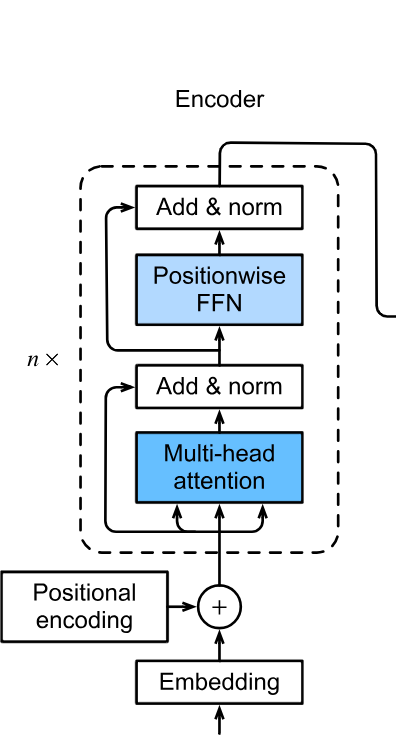

Tips in completing this section

* We will use the LSTM Encoder as input embedding.
* How many multi-head attention modules do we have.
* Can you seperate the encoder layer from the whole encoder architecture ?
* How do  we implement skip  connections
* How many layer norms do we have ?

## Transformer Encoder

In [ ]:
class EncoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        # @TODO: fill in the blanks appropriately (given the modules above)
        self.mha        = MultiHeadAttention(num_heads, d_model, dropout=dropout)
        self.ffn        = FeedForward(d_model, d_ff)

        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.dropout1   = nn.Dropout(p=dropout)
        self.dropout2   = nn.Dropout(p=dropout)

    def forward(self, inp, pad_mask, slf_attn_mask):

        # Multi-Head Attention
        #   (1) perform Multi-Head Attention on inp
        output1, attn_weights1 = self.mha(inp, inp, inp, slf_attn_mask )
        ''' TODO '''

        # Skip (Residual) Connection
        #   (1) perform dropout
        output1 = self.dropout1(output1)
        #   (2) add the input as a skip connection
        ''' TODO '''

        # Layer Normalization
        #   (1) call layernorm on this resulting value
        output1 = self.layernorm1(output1 +  inp)
        ''' TODO '''

        # Feed Forward Network
        #   (1) apply feed forward layer
        ffn_output = self.ffn(output1)
        ''' TODO '''

        # Skip (Residual) Connection
        #   (1) perform dropout
        ffn_output = self.dropout2(ffn_output)
        #   (2) add the output of the first layernorm as a skip connection
        output2 = self.layernorm2(ffn_output + output1)
        ''' TODO '''

        # Layer Normalization
        #   (1) call layernorm on this resulting value
        ''' TODO '''
        return output2, attn_weights1
        raise NotImplemented

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, num_layers, d_model, num_heads, d_ff, mfcc_max_seq_length, dropout=0.1):
        super(Encoder, self).__init__()

        # @TODO: fill in the blanks appropriately (given the modules above and P1 setup)
        self.embedding      = CNN_LSTM_Encoder(input_dim, 256, dropout)
        self.projection     = torch.nn.Linear(1024, d_model)
        self.pos_encoding   =  PositionalEncoding(d_model, max_len=mfcc_max_seq_length)

        # concatenating all num_layers EncoderLayer blocks
        self.enc_layers     = torch.nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.dropout        = nn.Dropout(dropout)
        self.layernorm      = torch.nn.LayerNorm(d_model)

    def forward(self, x, input_lengths):

        # apply the CNN-LSTM Encoder (embedding)
        ''' TODO '''
        # print("x shape", x.shape)
        encoder_output, encoder_lens = self.embedding(x, input_lengths)
        inp_embedded = self.projection(encoder_output)
        # adding projection layer to change dimension of encoder_outputs to match d_model
        ''' TODO '''

        # apply Positional Encoding on these extracted features
        ''' TODO '''
        inp_embedded = self.pos_encoding(inp_embedded)
        # apply dropout as regularization technique
        ''' TODO '''
        inp_embedded = self.dropout(inp_embedded)
        pad_mask = create_mask_1(inp_embedded,  encoder_lens)
        ''' TODO '''

        # create an attention mask -- sets padded area attention weights to infinity


        dec_enc_attn_mask = create_mask_3(encoder_output, encoder_lens,encoder_output.shape[1])

        # passing inputs through Transformer Encoder blocks
        ''' TODO '''
        for i, enc_layer in enumerate(self.enc_layers):
            inp_embedded, attn_weights1 = enc_layer(inp_embedded, pad_mask, dec_enc_attn_mask )

        return inp_embedded, encoder_lens
        raise NotImplemented

In [ ]:
class FullTransformer(torch.nn.Module):
    def __init__(self, input_dim, enc_num_layers, dec_num_layers, enc_num_heads, dec_num_heads,
                 d_model, d_ff, target_vocab_size, eos_token, sos_token,
                 pad_token, dropout=0.1, trans_max_seq_length=550, mfcc_max_seq_length=3260):

        super(FullTransformer, self).__init__()

        self.encoder = Encoder(input_dim, enc_num_layers, d_model, enc_num_heads, d_ff,
                               mfcc_max_seq_length,  dropout)

        self.decoder = Decoder(dec_num_layers, d_model, dec_num_heads, d_ff,
                               dropout, target_vocab_size, trans_max_seq_length, eos_token, sos_token, pad_token)

    def forward(self, padded_input, input_lengths, padded_target, target_lengths):
        # passing through Encoder
        encoder_output, encoder_lens = self.encoder(padded_input, input_lengths)

        # passing Encoder output and Attention masks through Decoder
        output, attention_weights = self.decoder(padded_target, encoder_output, encoder_lens)


        return output, attention_weights

    def recognize(self, inp, inp_len):
        """ sequence-to-sequence greedy search -- decoding one utterance at a time """

        encoder_outputs, encoder_lens = self.encoder(inp, inp_len)
        out = self.decoder.recognize_greedy_search(encoder_outputs, encoder_lens)

        return out

## Full Model Setup

In [ ]:
full_model = FullTransformer(
input_dim                   = config["input_dim"],
enc_num_layers              = config["enc_num_layers"],
dec_num_layers              = config["dec_num_layers"],
enc_num_heads               = config["enc_num_heads"],
dec_num_heads               = config["dec_num_heads"],

d_model                     = config["d_model"],
d_ff                        = config["d_ff"],

target_vocab_size           = len(VOCAB),
eos_token                   = EOS_TOKEN,
sos_token                   = SOS_TOKEN,
pad_token                   = PAD_TOKEN,

dropout                     = config["enc_dropout"],

# decrease to a small number if you are just trying to implement the network
# we've computed the max length of the transcripts for you
trans_max_seq_length        = 550,
mfcc_max_seq_length         = dataset_max_len).to(device)

In [ ]:
### Load your best P1 model checkpoint
# model.load_state_dict(torch.load('path to best P1 model checkpoint')['model_state_dict'])

Freezing model weights except for transformer encoder layers. This is like an initialization strategy so that the encoder learns the range of values required by the decoder. After about 3 epochs when this initialzation is done, unfreeze weights of the entire model and let it train.




In [ ]:
### Copy weights from P1 model to full model
### Freeze the weights of full transformer input embedding, linear projection, and decoder

full_model.encoder.embedding.load_state_dict(model.encoder.state_dict())
for param in full_model.encoder.embedding.parameters():
    param.requires_grad = False # TODO make it non-trainable

full_model.encoder.projection.load_state_dict(model.proj.state_dict())
for param in full_model.encoder.projection.parameters():
    param.requires_grad = False # TODO make it non-trainable

full_model.decoder.load_state_dict(model.decoder.state_dict())
for param in full_model.decoder.parameters():
    param.requires_grad = False # TODO make it non-trainable

In [ ]:
del model

## Loss, Optimizer, and Scheduler Definitions

In [ ]:
loss_func   = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN)
scaler      = torch.cuda.amp.GradScaler()

In [ ]:
''' defining optimizer '''

if config["optimizer"] == "SGD":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.SGD(full_model.parameters(),
                              lr=config["learning_rate"],
                              momentum=config["momentum"],
                              weight_decay=1E-4,
                              nesterov=config["nesterov"])

elif config["optimizer"] == "Adam":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.Adam(full_model.parameters(),
                               lr=float(config["learning_rate"]),
                               weight_decay=1e-4)

elif config["optimizer"] == "AdamW":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.AdamW(full_model.parameters(), lr=float(config["learning_rate"]),
                                betas=(0.9, 0.999),
                                eps=1e-9,
                                weight_decay=0.01)

''' defining scheduler '''

if config["scheduler"] == "ReduceLR":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                factor=config["factor"], patience=config["patience"], min_lr=1E-8, verbose=True)

elif config["scheduler"] == "CosineAnnealing":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                T_max = config["epochs"], eta_min=1E-8)

## Experiments

In [ ]:
###  Now let's train the encoder to master the encoder input ranges
e                   = 0
best_loss           = 10.0

checkpoint_root = os.path.join(os.getcwd(), 'checkpointsfull')
os.makedirs(checkpoint_root, exist_ok=True)
wandb.watch(full_model, log="all")

checkpoint_best_loss_model_filename     = 'checkpoint-best-loss-modelfull.pth'
checkpoint_last_epoch_filename          = 'checkpoint-epochfull-'
best_loss_model_path                    = os.path.join(checkpoint_root, checkpoint_best_loss_model_filename)

if RESUME_LOGGING:
    # change if you want to load best test model accordingly
    checkpoint = torch.load(wandb.restore(checkpoint_best_loss_model_filename, run_path=""+run_id).name)

    full_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    e = checkpoint['epoch']

    print("Resuming from epoch {}".format(e+1))
    print("Epochs left: ", config['epochs']-e)
    print("Optimizer: \n", optimizer)

torch.cuda.empty_cache()
gc.collect()

epochs = config["epochs"]
for epoch in range(e, epochs):

    print("\nEpoch {}/{}".format(epoch+1, config["epochs"]))

    curr_lr = float(optimizer.param_groups[0]["lr"])

    train_loss, train_perplexity, attention_weights = train_model(full_model, train_loader, optimizer)

    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Train Perplexity {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config["epochs"], train_loss, train_perplexity, curr_lr))

    if (epoch % 2 == 0):    # validate every 2 epochs to speed up training
        levenshtein_distance = validate_fast(full_model, val_loader)
        print("Levenshtein Distance {:.04f}".format(levenshtein_distance))

        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr,
                "val_distance"      : levenshtein_distance})

    else:
        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr})

    # plotting the encoder-nearest and decoder-nearest attention weights
    attention_keys = list(attention_weights.keys())

    # plot_attention_weights((attention_weights[attention_keys[0]][0]).cpu().detach().numpy())
    # plot_attention_weights(attention_weights[attention_keys[-1]][0].cpu().detach().numpy())

    attention_weights_decoder_self       = attention_weights[attention_keys[0]][0].cpu().detach().numpy()
    attention_weights_decoder_cross      = attention_weights[attention_keys[-1]][0].cpu().detach().numpy()
    save_attention_plot(attention_weights_decoder_cross, epoch)

    if config["scheduler"] == "ReduceLR":
        scheduler.step(levenshtein_distance)
    else:
        scheduler.step()

    ### Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best
    epoch_model_path = os.path.join(checkpoint_root, (checkpoint_last_epoch_filename + str(epoch) + '.pth'))
    save_model(full_model, optimizer, scheduler, ['train_loss', train_loss], epoch, epoch_model_path)
    ## wandb.save(epoch_model_path) ## Can't save on wandb for all epochs, may blow up storage

    print("Saved epoch model")

    # the first time we add the transformer encoder block, we freeze all other weights
    #   except the transformer encoder weights and train this partially-frozen model
    #   for about 3 epochs to weight initialize the transformer encoder weights.
    #   This speeds up convergence of the entire network.
    # if epoch == 3:##   WWATCH OUT
    #     break

    if best_loss <= train_loss:
        best_loss = train_loss
        save_model(full_model, optimizer, scheduler, ['train_loss', train_loss], epoch, best_loss_model_path)
        # wandb.save(best_loss_model_path)
        print("Saved best training model")

### Finish your wandb run
# run.finish()

In [ ]:
validate_full(full_model, val_loader)

In [ ]:
### TODO Unfreeze the weights of full transformer input embedding and decoder
# @NOTE: after unfreezing, continue training the P2 model for more epochs to achieve best results!

for param in full_model.encoder.embedding.parameters():
    param.requires_grad = True # TODO make it trainable

for param in full_model.encoder.projection.parameters():
    param.requires_grad = True # TODO make it trainable

for param in full_model.decoder.parameters():
    param.requires_grad = True # TODO make it trainable

## Testing

In [ ]:
full_model.eval()

# progress bar
batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc="Test", ncols=5)

all_predictions = []

for i, data in enumerate(test_loader):
    inputs, inputs_lengths = data
    inputs                 = inputs.to(device)

    with torch.inference_mode():
        greedy_predictions = full_model.recognize(inputs, inputs_lengths)

    greedy_predictions = greedy_predictions.detach().cpu().numpy()

    for batch_idx in range(greedy_predictions.shape[0]):
        pred_sliced = indices_to_chars(greedy_predictions[batch_idx], vocab= VOCAB)
        pred_string = ''.join(pred_sliced)
        all_predictions.append(pred_string)

    batch_bar.update()

In [ ]:
# %cd /content/
df = pd.DataFrame({
    "index" : list(range(len(all_predictions))),
    "label" : all_predictions
})

df.to_csv("improved.csv", index=False)

In [ ]:
!kaggle competitions submit -c hw4p2-sp24 -f improved.csv -m "It's been a ride :)"

# Part #3 (Improving your Model)
* Think of the input embedding, can you have something better than just an CNN-LSTM? Hint: HW3P2 might perform better.
* Think about the transformer encoder parameter, what about number of heads and number of layers, can this help?
* What about the decoder parameters what can  we improve there?
* We trained using an incremental training technique, can we use this technique to add more layers?

**Good Luck!!**